# Chapter 2

## 2.3 Numerical integration of the SIR model

In [1]:
using OrdinaryDiffEq
using LabelledArrays
using DataFrames
using Plots;

Step 1: define the function.

In [2]:
function sirmod(u, p, t)
    S,I,R = u
    β = p.β
    μ = p.μ
    γ = p.γ
    N = p.N
    dS = μ*(N-S) - β*S*I/N
    dI = β*S*I/N - (μ+γ)*I
    dR = γ*I - μ*R
    [dS, dI, dR]
end;

Steps 2-4: define the time, the parameters, and the initial conditions.

In [3]:
t0 = 0.0
t1 = 0.5
δt = 1.0/365
p = LVector(μ=0.0, N=1.0, R₀=4.0, γ=365.0/14)
p = [p; LVector(β=p.R₀*p.γ + p.μ)]
u0 = [0.999, 0.001, 0.0] .* p.N;

Step 5: solve the model.

In [4]:
prob = ODEProblem(sirmod, u0, (t0, t1), p)
sol = solve(prob, Rodas5P(); saveat=δt);

In [5]:
out = DataFrame(sol)
rename!(out, [:time, :S, :I, :R])
first(round.(out, digits = 3), 6)


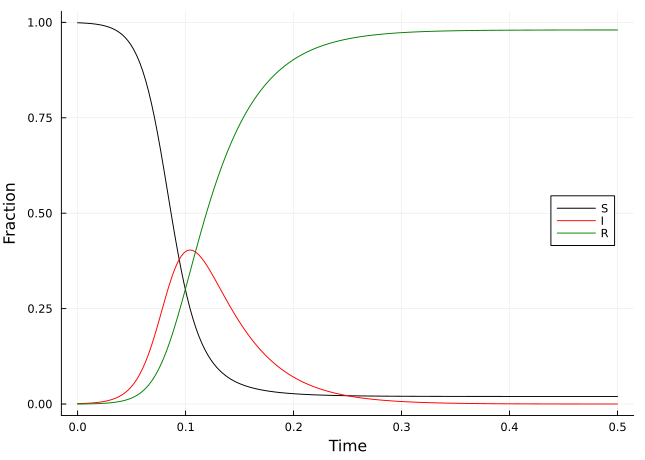

In [6]:
plot(out.time, out.S, ylabel="Fraction", xlabel="Time", color=:black, label="S", legend=:right)
plot!(out.time, out.I, color=:red, label="I")
plot!(out.time, out.R, color=:green, label="R")

## 2.4 Final epidemic size

Find final epidemic size by running to steady state.

In [7]:
using SteadyStateDiffEq
ssprob = SteadyStateProblem(sirmod, u0, p)
sssol = solve(ssprob, DynamicSS(Rodas5P()))
round.(sssol, digits=2)

3-element Vector{Float64}:
  0.02
 -0.0
  0.98

Calculate final size over a range of values of R₀.

In [8]:
nsims = 50
R₀ = range(0.1, 5, nsims)
betas = R₀ .* p.γ .+ p.μ
fs = Array{Float64}(undef, nsims)
for i in 1:nsims
    sp = remake(ssprob, p=LVector(μ=0.0, N=1.0, γ=365.0/14, β=betas[i]))
    ss = solve(sp, DynamicSS(Rodas5P()))
    fs[i] = ss[3]
end


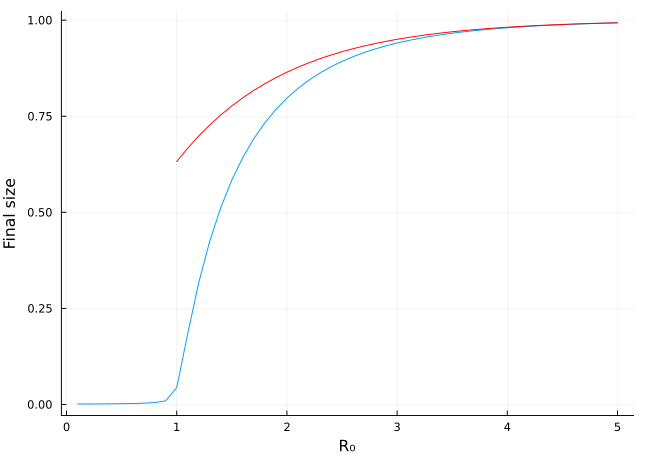

In [9]:
plot(R₀, fs, xlabel="R₀", ylabel="Final size", legend=false)
x = 1:0.1:5
plot!(x, 1 .- exp.(-x), color=:red)    

Use root-finding to calculate the final size.

In [10]:
using NonlinearSolve
fn(u, p) = exp(-(p[1]*(1-u[1]))) - u[1]
rprob = IntervalNonlinearProblem(fn, (0.0, 1.0 - 1e-9), [2.0])
rsol = solve(rprob, Falsi())
1.0 - rsol.u[1]

0.7968121300200202

## 2.5 The open epidemic

In [11]:
t0 = 0.0
t1 = 50.0
δt = 1.0/365
p = LVector(μ=1.0/50, N=1.0, R₀=4.0, γ=365.0/14)
p = [p; LVector(β=p.R₀*p.γ + p.μ)]
u0 = [0.1999, 0.0001, 0.8] .* p.N
prob = ODEProblem(sirmod, u0, (t0, t1), p)
sol = solve(prob, Rodas5P(); saveat=δt)
out = DataFrame(sol)
rename!(out, [:time, :S, :I, :R]);


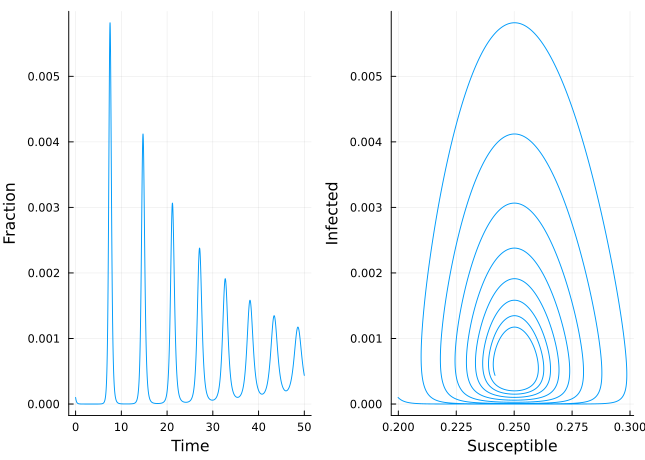

In [12]:
l = @layout [a b]
p1 = plot(t0:δt:t1, out.I, xlabel="Time", ylabel="Fraction", legend=false)
p2 = plot(out.S, out.I, xlabel="Susceptible", ylabel="Infected", legend=false)
plot(p1, p2, layout=l)